In [1]:
import os
import Loader
import numpy as np
from mne import viz
from scipy import io
from matplotlib import colors, pyplot as plt
from sklearn import preprocessing, model_selection, ensemble

In [2]:
CAF_DOSE = 200

PROJECT_PATH = 'E:\\Cafeine_data'

STAGES = ['AWA', 'N1', 'N2', 'N3', 'REM']

In [3]:
sensor_pos = io.loadmat(os.path.join(PROJECT_PATH, 'Coo_caf'))['Cor'].T
sensor_pos = np.array([sensor_pos[1], sensor_pos[0]]).T

In [4]:
subject_labels = Loader.load_labels(CAF_DOSE)

spec_shan_en = Loader.load_feature('SpecShanEn', CAF_DOSE)
spec_perm_en = Loader.load_feature('SpecPermEn', CAF_DOSE)
spec_samp_en = Loader.load_feature('SpecSampEn', CAF_DOSE)
samp_en = Loader.load_feature('SampEn', CAF_DOSE)

features = [(spec_shan_en, 20), (spec_shan_en, 20), (spec_samp_en, 20), (samp_en, 20)]
data, labels = Loader.prepare_features(features, subject_labels)

In [5]:
x_train, x_test, y_train, y_test = {}, {}, {}, {}
for stage in STAGES:
    split = model_selection.train_test_split(data[stage], labels[stage], test_size=0.2, shuffle=True)
    x_train[stage], x_test[stage], y_train[stage], y_test[stage] = split

    scaler = preprocessing.StandardScaler()
    scaler.fit(x_train[stage])

    x_train[stage] = scaler.transform(x_train[stage])
    x_test[stage] = scaler.transform(x_test[stage])

In [6]:
rfs = {}
for stage in STAGES:
    print(f'Training random forest on sleep stage {stage}...')
    rfs[stage] = ensemble.RandomForestClassifier(n_estimators=200)
    rfs[stage].fit(x_train[stage], y_train[stage])

Training random forest on sleep stage AWA...
Training random forest on sleep stage N1...
Training random forest on sleep stage N2...
Training random forest on sleep stage N3...
Training random forest on sleep stage REM...


In [7]:
for stage in STAGES:
    acc_train = rfs[stage].score(x_train[stage], y_train[stage]) * 100
    acc_test = rfs[stage].score(x_test[stage], y_test[stage]) * 100
    print(f'Accuracy for training data: {acc_train:.3f}%, testing data: {acc_test:.3f}%')

Accuracy for training data: 100.000%, testing data: 79.102%
Accuracy for training data: 100.000%, testing data: 65.012%
Accuracy for training data: 100.000%, testing data: 64.305%
Accuracy for training data: 100.000%, testing data: 64.684%
Accuracy for training data: 100.000%, testing data: 71.181%


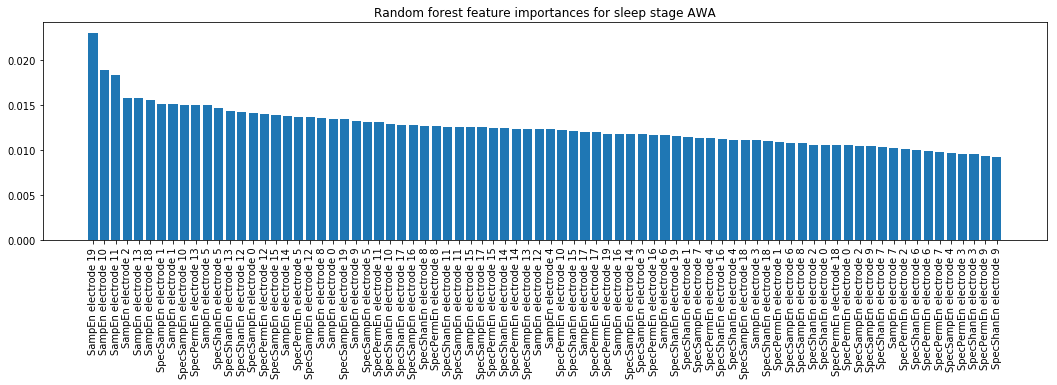

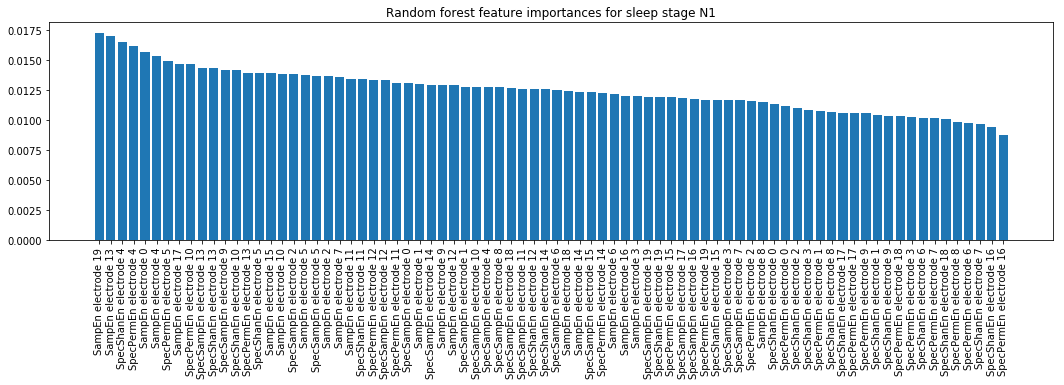

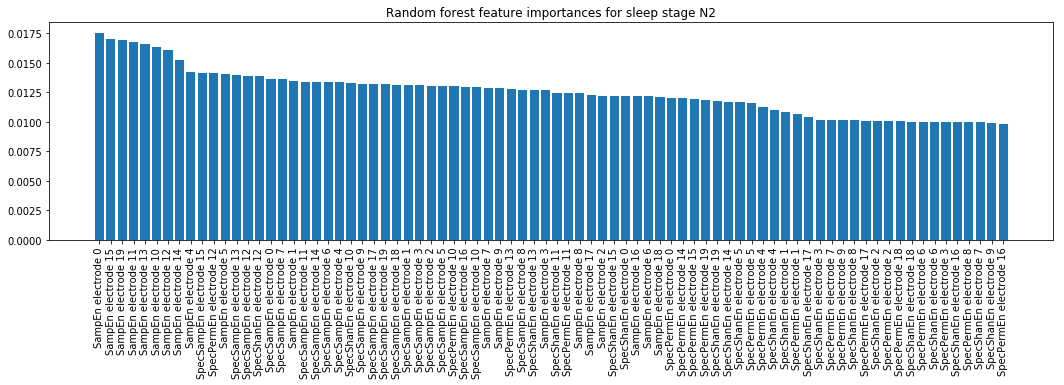

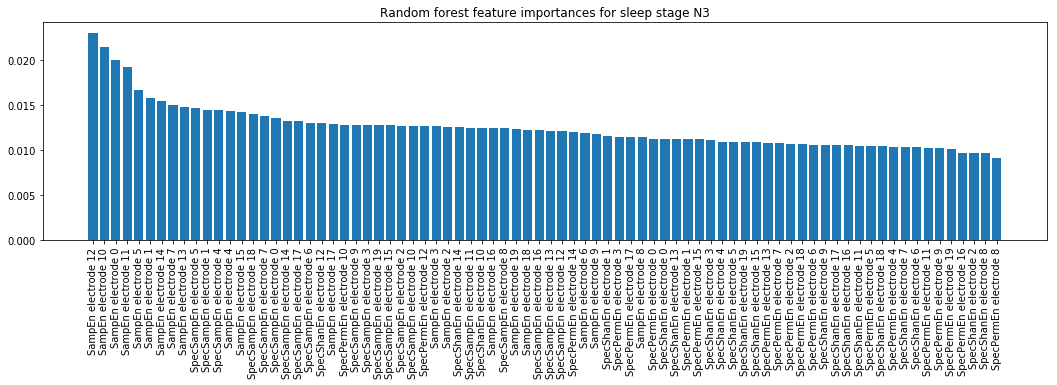

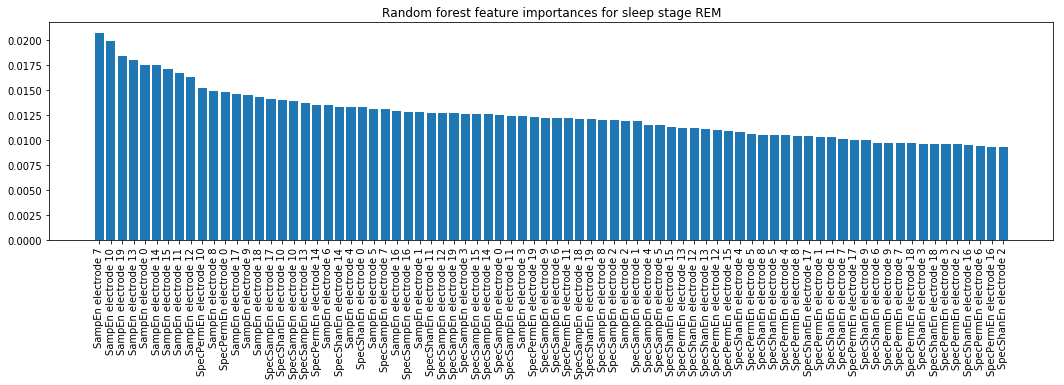

In [8]:
feature_names = []

for electrode in range(20):
    feature_names.append(f'SpecShanEn electrode {electrode}')
for electrode in range(20):
    feature_names.append(f'SpecPermEn electrode {electrode}')
for electrode in range(20):
    feature_names.append(f'SpecSampEn electrode {electrode}')
for electrode in range(20):
    feature_names.append(f'SampEn electrode {electrode}')


for stage in STAGES:
    indices = np.argsort(rfs[stage].feature_importances_)[::-1]
    
    plt.figure(figsize=(18, 4))
    plt.title(f'Random forest feature importances for sleep stage {stage}')
    plt.bar(np.arange(len(indices)), rfs[stage].feature_importances_[indices])
    plt.xticks(np.arange(len(indices)), np.array(feature_names)[indices], rotation=90)
    plt.show()

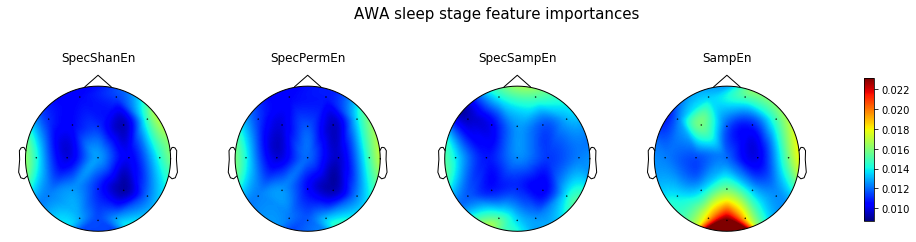

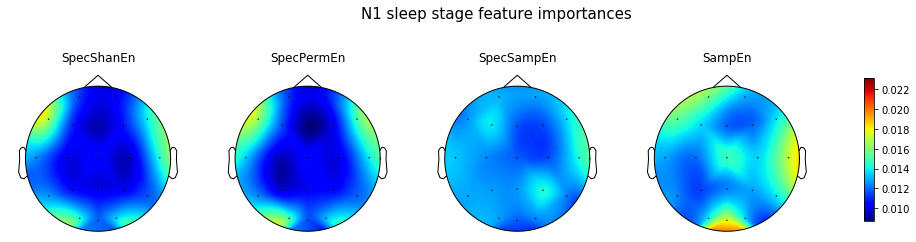

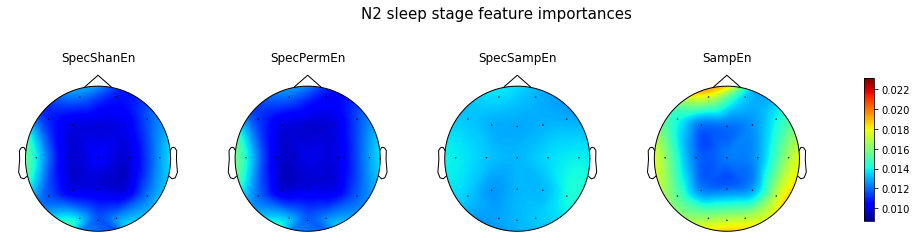

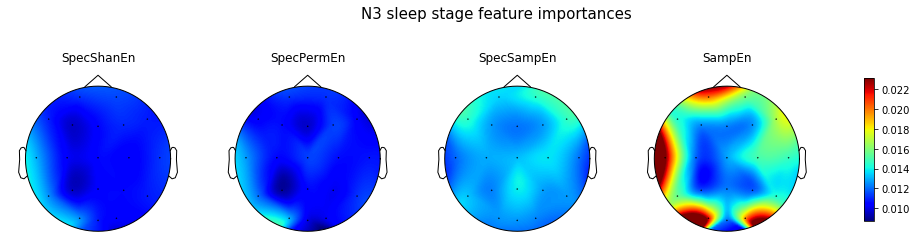

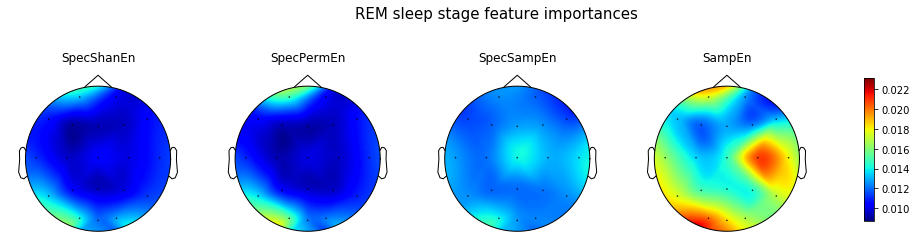

In [9]:
importances = dict([(stage, rfs[stage].feature_importances_) for stage in STAGES])
vmin = np.min([importances[stage].min() for stage in STAGES])
vmax = np.max([importances[stage].max() for stage in STAGES])

colormap = 'jet'
names = ['SpecShanEn', 'SpecPermEn', 'SpecSampEn', 'SampEn']

for stage in STAGES:
    plt.figure(figsize=(18, 3))
    plt.suptitle(f'{stage} sleep stage feature importances', y=1.2, fontsize=15)

    axes = []
    for i in range(4):
        ax = plt.subplot(1, 4, i + 1)
        axes.append(ax)
        plt.title(names[i])
        viz.plot_topomap(importances[stage][i*20:i*20+20], sensor_pos, cmap=colormap, vmin=vmin, vmax=vmax, contours=False, show=False)
    
    norm = colors.Normalize(vmin=vmin,vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=axes, shrink=0.8, aspect=15)
    plt.show()